<a href="https://colab.research.google.com/github/BenAppio2/Final_Assignment/blob/main/Final_Assignment_Appio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Option 2: Read directly from GitHub

canada_births_1991_2022 <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-01-09/canada_births_1991_2022.csv')
nhl_player_births <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-01-09/nhl_player_births.csv')
nhl_rosters <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-01-09/nhl_rosters.csv')
nhl_teams <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-01-09/nhl_teams.csv')

Rows: 384 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): year, month, births

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8474 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): first_name, last_name, birth_city, birth_country, birth_state_prov...
dbl  (3): player_id, birth_year, birth_month
date (1): birth_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 54883 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): team_code, position_type, headshot, first_name, last_name, positi...
dbl   (7): season, player_id, sweater_number, height_in_inches, weight_in_po...


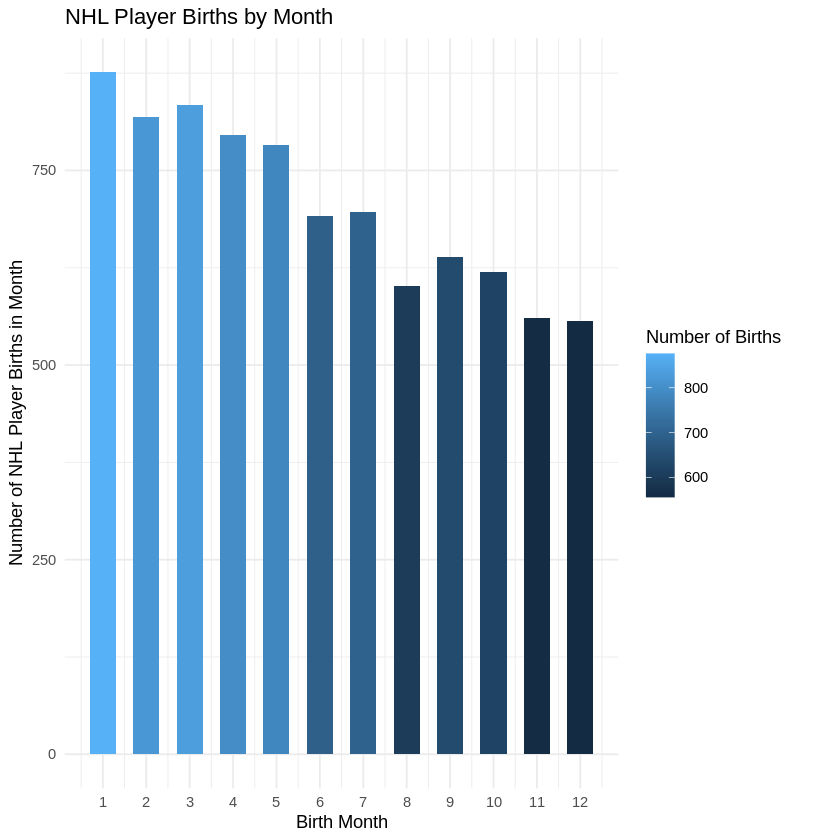

In [10]:
# Libraries
library(ggplot2)
library(dplyr)

nhl_player_births %>%
  group_by(birth_month) %>%
  count() %>%
  ggplot(aes(x = birth_month, y = n, fill =  n)) +
  geom_col(width = 0.6) +
  labs(x = "Birth Month", y = "Number of NHL Player Births in Month", title = "NHL Player Births by Month", fill = "Number of Births") +
  theme_minimal() + scale_x_continuous(breaks=seq(1,12,1))

# This shows something already expected that Canadian NHL players are born earlier in the year due to maturing many months before
## other children in youth sports - thus being recruited to better teams and access to more resources

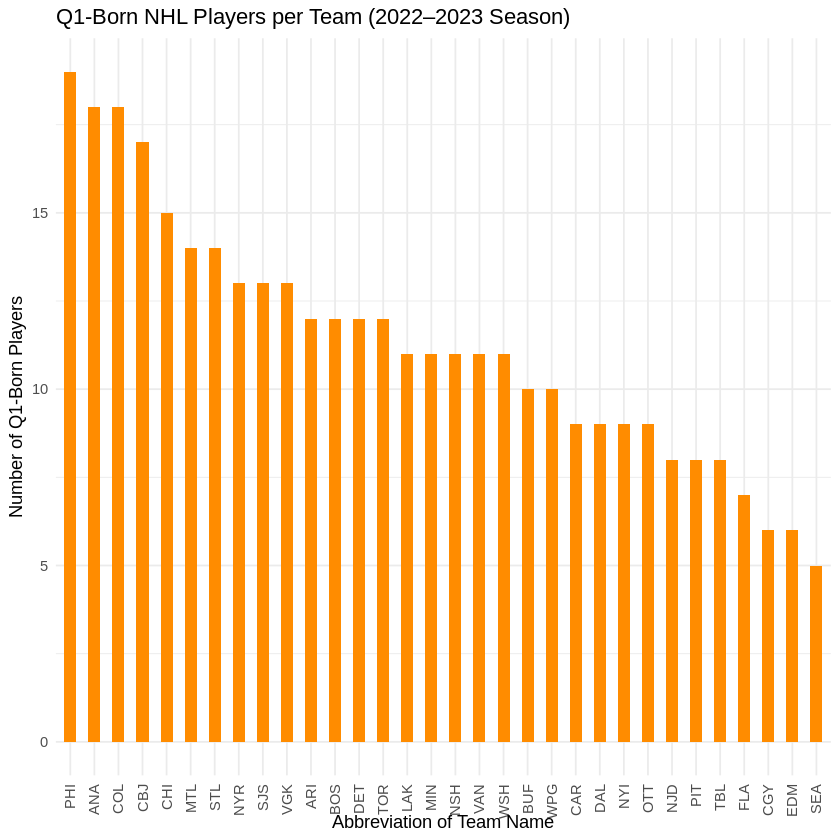

In [11]:
# I want to see which teams have the most players born in the quarter months of the year,
## As shown the barplot above, most of the players are born in the beginning of the year
### This data could help predict a record of a season - only used data for 2022-2023 season

#### Tidy Tuesday did not provide data on NHL team's record or number of championships ####

# Deduplicating nhl_player_births before joining - players sometime occur more than once in list
deduped_births <- nhl_player_births %>%
  distinct(player_id, .keep_all = TRUE)  # keep first occurrence of each player

# Joining data on player_id
combined_df <- left_join(nhl_rosters, deduped_births, by = "player_id")

# Filtering for 2022–2023 season only
one_season_df <- combined_df %>%
  filter(season == 20222023)

# Filtering players born in Q1 (Jan–Mar)
q1_births <- one_season_df %>%
  filter(birth_month %in% c(1, 2, 3))

# Counting Q1-born players per team
team_q1_counts <- q1_births %>%
  group_by(team_code) %>%
  summarise(q1_player_count = n()) %>%
  arrange(desc(q1_player_count))

# Plotting the bar plot
ggplot(team_q1_counts, aes(x = reorder(team_code, -q1_player_count), y = q1_player_count)) +
  geom_col(fill = "darkorange", width = 0.5) +
  labs(title = "Q1-Born NHL Players per Team (2022–2023 Season)",
       x = "Abbreviation of Team Name",
       y = "Number of Q1-Born Players") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))


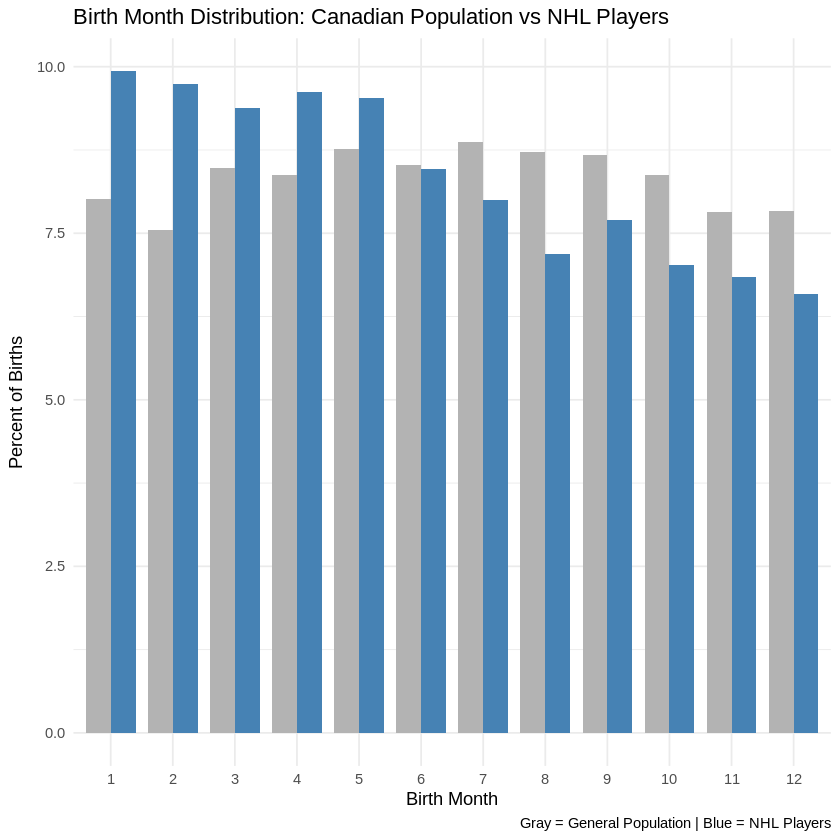

In [12]:
# I wanted to see if there were generally more births in the beginning of the months in Canada
## to see if it just a case of quantity over quality

# Sum births by month across all years
monthly_canada_births <- canada_births_1991_2022 %>%
  group_by(month) %>%
  summarise(total_births = sum(births)) %>%
  mutate(percent_births = total_births / sum(total_births) * 100)

# Only Canadian-born players
canadian_nhl_births <- nhl_player_births %>%
  filter(birth_country == "CAN")

# Count NHL player births by month
monthly_nhl_births <- canadian_nhl_births %>%
  group_by(birth_month) %>%
  summarise(nhl_player_births = n()) %>%
  mutate(percent_nhl = nhl_player_births / sum(nhl_player_births) * 100)

comparison_df <- left_join(monthly_canada_births, monthly_nhl_births, by = c("month" = "birth_month"))

ggplot(comparison_df, aes(x = factor(month))) +
  geom_col(aes(y = percent_births), fill = "gray70", width = 0.4, position = position_nudge(x = -0.2)) +
  geom_col(aes(y = percent_nhl), fill = "steelblue", width = 0.4, position = position_nudge(x = 0.2)) +
  labs(title = "Birth Month Distribution: Canadian Population vs NHL Players",
       x = "Birth Month", y = "Percent of Births",
       caption = "Gray = General Population | Blue = NHL Players") +
  theme_minimal()


# A tibble: 2 × 3
  nationality     n percent
  <chr>       <int>   <dbl>
1 Canada       5468    64.5
2 Non-Canada   3006    35.5


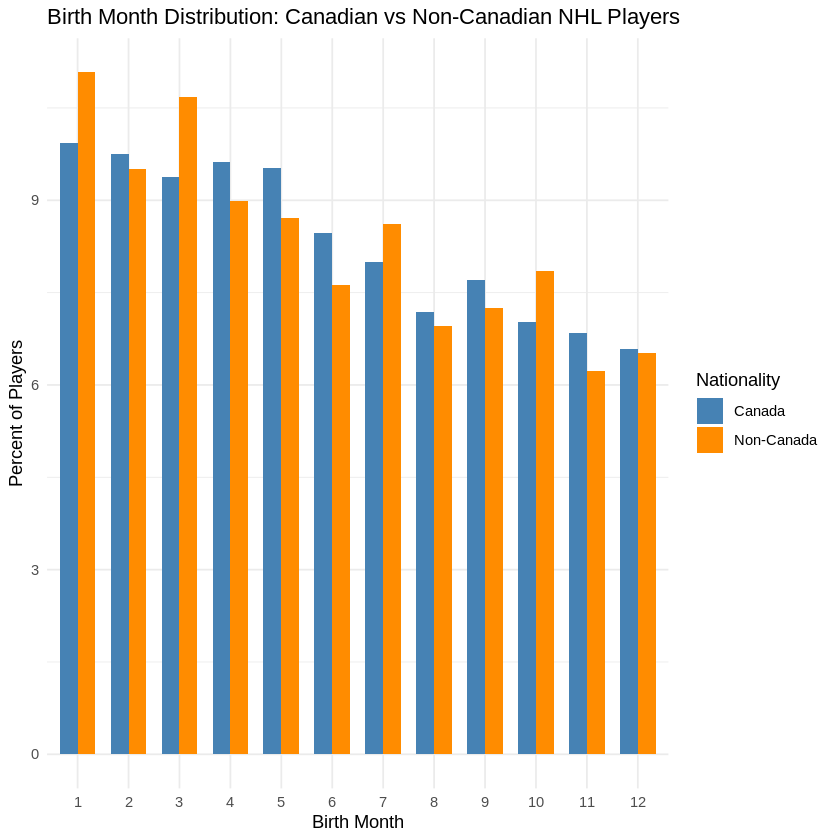

In [21]:
# The first data chart shows that over half of the NHL total players are born in Canada
## This makes sense since hockey is such a popular sport in the country
### I wanted to see if the trend of players born in the beginning of the year is the same for the rest of the world

# Count total players by country group
nationality_summary <- nhl_player_births %>%
  mutate(nationality = ifelse(birth_country == "CAN", "Canada", "Non-Canada")) %>% # If the player as a nationality as "CAN" then label it "Canada" -- If not, then the player is "Non-Canada"
  group_by(nationality) %>%
  summarise(n = n()) %>%
  mutate(percent = round(n / sum(n) * 100, 1))

print(nationality_summary)


# Creating Canadian vs Non-Canadian groups to be able to compare them
births_by_nationality <- nhl_player_births %>%
  mutate(nationality = ifelse(birth_country == "CAN", "Canada", "Non-Canada")) %>%
  group_by(nationality, birth_month) %>%
  summarise(n = n(), .groups = "drop") %>%
  group_by(nationality) %>%
  mutate(percent = n / sum(n) * 100)

# Plot the birth month distribution
ggplot(births_by_nationality, aes(x = factor(birth_month), y = percent, fill = nationality)) +
  geom_col(position = "dodge", width = 0.7) +
  labs(
    title = "Birth Month Distribution: Canadian vs Non-Canadian NHL Players",
    x = "Birth Month",
    y = "Percent of Players",
    fill = "Nationality"
  ) +
  scale_fill_manual(values = c("Canada" = "steelblue", "Non-Canada" = "darkorange")) +
  theme_minimal()

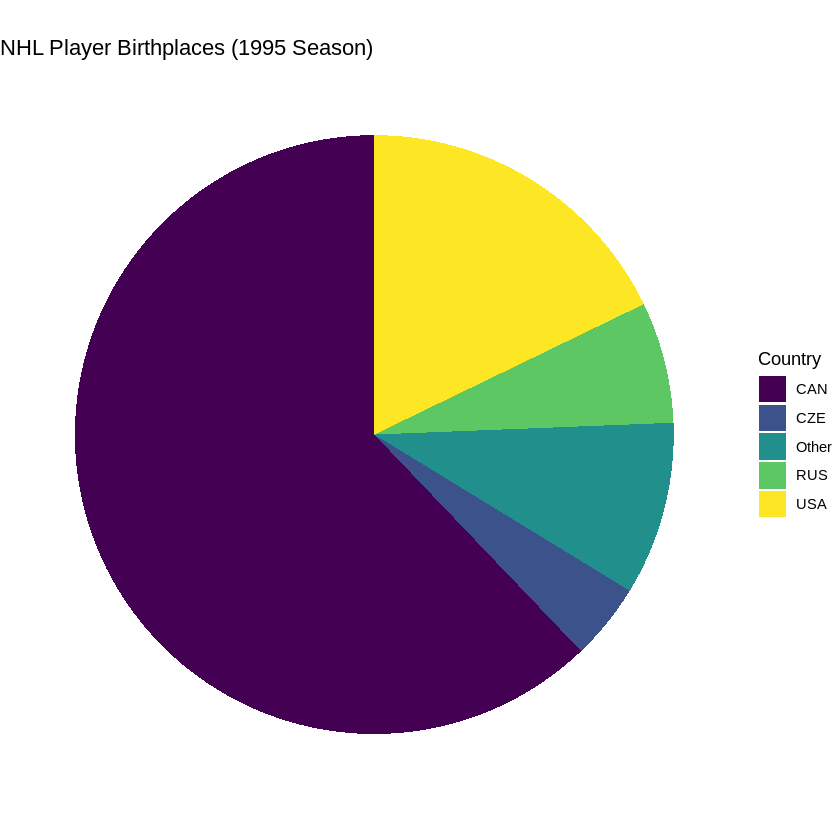

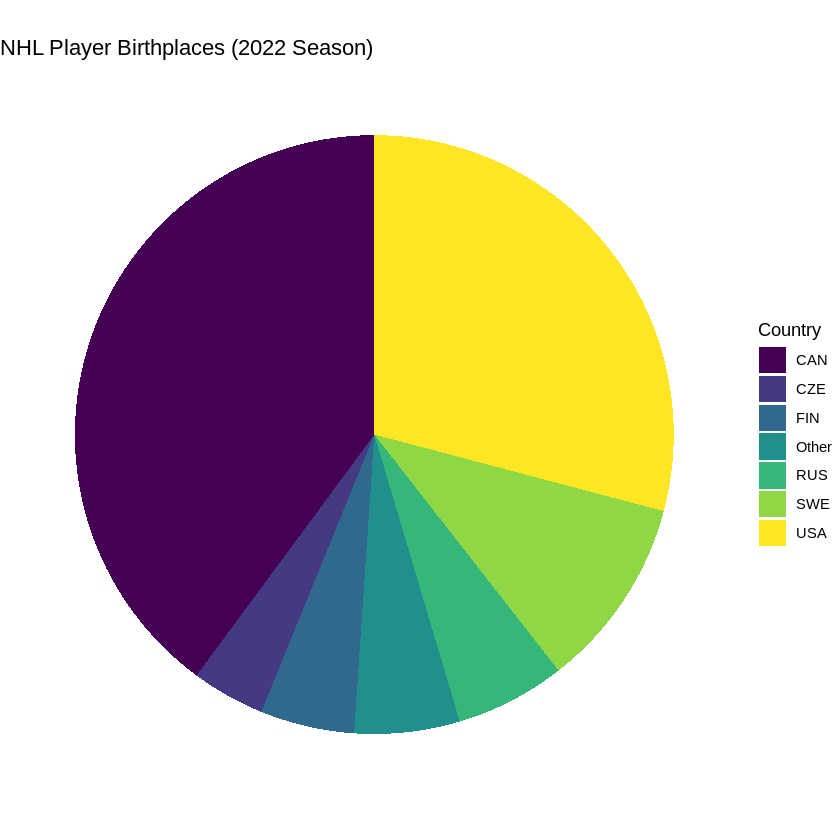

In [14]:
## I wanted to see the difference the 1995 player birth countries vs to a more recent
## 2022-2023 season. Two pie charts next to each other will be made for a good visual
## Comparison

# Filter 1995 and join cleanly
roster_1995 <- nhl_rosters %>%
  filter(season == 19951996) %>%
  left_join(nhl_player_births %>% select(player_id, birth_country) %>% distinct(player_id, .keep_all = TRUE) %>%
              rename(birth_country_births = birth_country),
            by = "player_id")

# Count players by birth country
country_counts <- roster_1995 %>%
  group_by(birth_country_births) %>%
  summarise(player_count = n(), .groups = "drop")

# Group small countries into "Other"
country_counts_clean <- country_counts %>%
  mutate(country_grouped = ifelse(player_count < 40, "Other", birth_country_births)) %>%
  group_by(country_grouped) %>%
  summarise(player_count = sum(player_count), .groups = "drop")

# Pie chart
ggplot(country_counts_clean, aes(x = "", y = player_count, fill = country_grouped)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y") +
  scale_fill_viridis_d(option = "viridis") +
  labs(title = "NHL Player Birthplaces (1995 Season)",
       fill = "Country") +
  theme_void()

## Now we're just going to do the same thing with the 2022-2023 season to compare the ##
## Number of players from each country ##


# Filter 2022 and join cleanly
roster_1995 <- nhl_rosters %>%
  filter(season == 20222023) %>%
  left_join(nhl_player_births %>% select(player_id, birth_country) %>% distinct(player_id, .keep_all = TRUE) %>%
              rename(birth_country_births = birth_country),
            by = "player_id")

# Count players by birth country
country_counts <- roster_1995 %>%
  group_by(birth_country_births) %>%
  summarise(player_count = n(), .groups = "drop")

# Group small countries into "Other"
country_counts_clean <- country_counts %>%
  mutate(country_grouped = ifelse(player_count < 40, "Other", birth_country_births)) %>%
  group_by(country_grouped) %>%
  summarise(player_count = sum(player_count), .groups = "drop")

# Pie chart
ggplot(country_counts_clean, aes(x = "", y = player_count, fill = country_grouped)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y") +
  scale_fill_viridis_d(option = "viridis") +
  labs(title = "NHL Player Birthplaces (2022 Season)",
       fill = "Country") +
  theme_void()

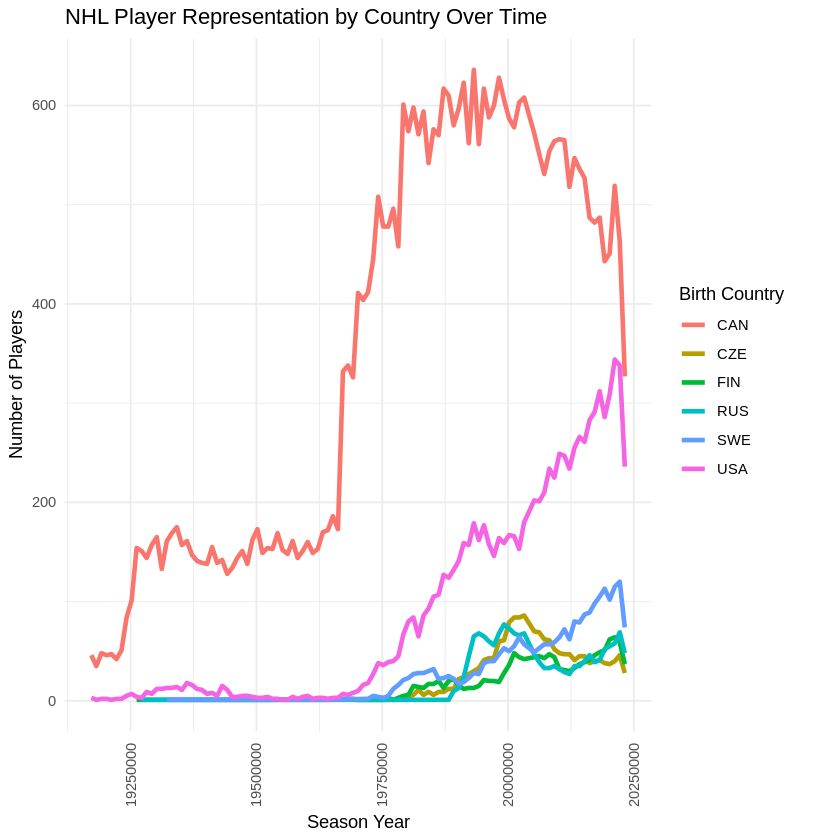

In [15]:
# I want to see the trend of the game growing worldwide, as it seems to be dominated by Canada
## This summarizes the top 6 countries with total players in the NHL and their growth trend
### nhl_rosters.cvs has the date with four zeros at the end for it to be "2022-2023" season

country_trend <- nhl_rosters %>%
  group_by(season, birth_country) %>%
  summarise(player_count = n(), .groups = "drop")

# Top 6 countries overall
top_countries <- country_trend %>%
  group_by(birth_country) %>%
  summarise(total = sum(player_count)) %>%
  arrange(desc(total)) %>%
  slice_head(n = 6) %>% # Allows us to only see the top 6 countries
  pull(birth_country)

# Filter to just those six countries
country_trend_filtered <- country_trend %>%
  filter(birth_country %in% top_countries)


# Plot
ggplot(country_trend_filtered, aes(x = season, y = player_count, color = birth_country)) +
  geom_line(size = 1.3) +
  labs(title = "NHL Player Representation by Country Over Time",
       x = "Season Year",
       y = "Number of Players",
       color = "Birth Country") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5))


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 29 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 29 rows containing missing values or values outside the scale range
(`geom_point()`).”


# A tibble: 3 × 2
  position_type correlation
  <chr>               <dbl>
1 defensemen          0.731
2 forwards            0.761
3 goalies             0.739


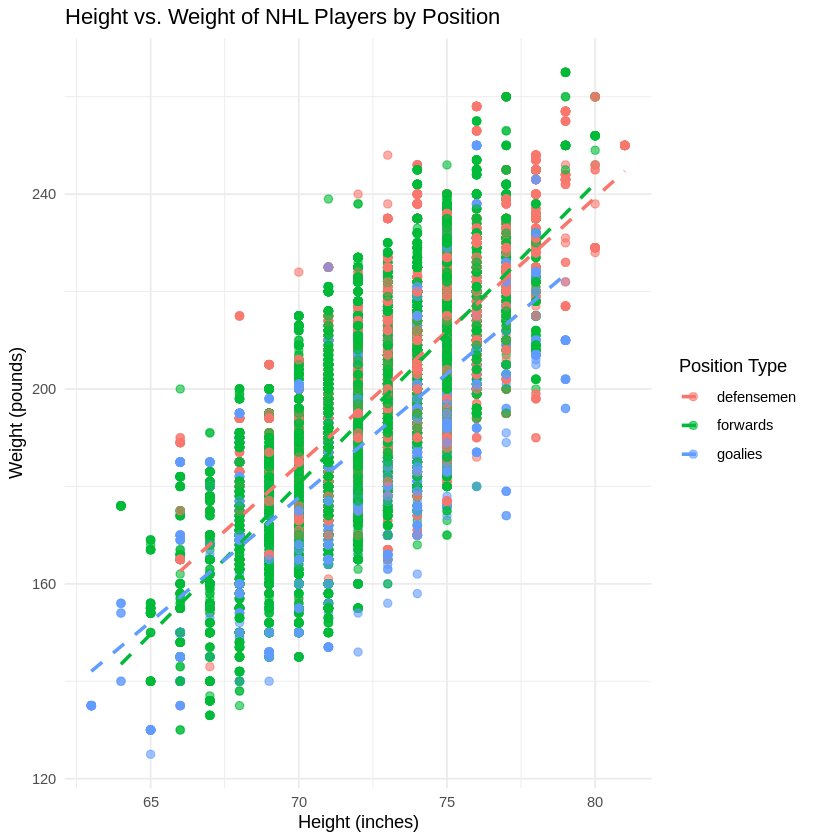

In [18]:
# Instead of focusing on the birth data, we looked at individual player data and if there
## were any correlations with their physical dimensions and their positions
### A correlation analysis was run to see if there is a correlation between height and weight
#### for each position

# Scatter plot
ggplot(nhl_rosters, aes(x = height_in_inches, y = weight_in_pounds, color = position_type)) +
  geom_point(alpha = 0.6, size = 2) +
  geom_smooth(method = "lm", se = FALSE, linetype = "dashed") +
  labs(title = "Height vs. Weight of NHL Players by Position",
       x = "Height (inches)",
       y = "Weight (pounds)",
       color = "Position Type") +
  theme_minimal()

# Remove missing values - not letting me obtain correlation without it
clean_df <- nhl_rosters %>%
  filter(!is.na(height_in_inches), !is.na(weight_in_pounds))

# Grouped correlation
cor_by_position <- clean_df %>%
  group_by(position_type) %>%
  summarise(correlation = cor(height_in_inches, weight_in_pounds, use = "complete.obs"))

print(cor_by_position)

